In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123


In [2]:

df = pd.read_csv(os.path.join("data", "processed", "train.csv"))
df = df.drop(columns=["train", "relativeposition", "spaceid"])

df_valid = pd.read_csv(os.path.join("data", "processed", "test.csv"))
df_valid = df_valid.drop(columns=["train", "relativeposition", "spaceid"])


In [3]:

X = df.drop(columns=["longitude", "latitude", "floor", "buildingid"])
y_lon = df.longitude
y_lat = df.latitude
y_floor = df.floor
y = pd.DataFrame({"lon": y_lon, "lat": y_lat, "floor": y_floor})

X_valid = df_valid.drop(columns=["longitude", "latitude", "floor", "buildingid"])
y_valid_lon = df_valid.longitude
y_valid_lat = df_valid.latitude
y_valid_floor = df_valid.floor
y_valid = pd.DataFrame({"lon": y_valid_lon, "lat": y_valid_lat, "floor": y_valid_floor})


In [4]:

X_train, X_test, y_train_lon, y_test_lon = train_test_split(
    X,
    y_lon,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

_, _, y_train_lat, y_test_lat = train_test_split(
    X,
    y_lat,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

_, _, y_train_floor, y_test_floor = train_test_split(
    X,
    y_floor,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

y_train = pd.DataFrame({"lon": y_train_lon, "lat": y_train_lat, "floor": y_train_floor})

y_test = pd.DataFrame({"lon": y_test_lon, "lat": y_test_lat, "floor": y_test_floor})


In [5]:


def _get_weights(dist, weights):
    """Get the weights from an array of distances and a parameter ``weights``

    Parameters
    ----------
    dist : ndarray
        The input distances
    weights : {'uniform', 'distance' or a callable}
        The kind of weighting used

    Returns
    -------
    weights_arr : array of the same shape as ``dist``
        if ``weights == 'uniform'``, then returns None
    """
    if weights in (None, "uniform"):
        return None
    elif weights == "distance":
        # if user attempts to classify a point that was zero distance from one
        # or more training points, those training points are weighted as 1.0
        # and the other points as 0.0
        if dist.dtype is np.dtype(object):
            for point_dist_i, point_dist in enumerate(dist):
                # check if point_dist is iterable
                # (ex: RadiusNeighborClassifier.predict may set an element of
                # dist to 1e-6 to represent an 'outlier')
                if hasattr(point_dist, "__contains__") and 0.0 in point_dist:
                    dist[point_dist_i] = point_dist == 0.0
                else:
                    dist[point_dist_i] = 1.0 / point_dist
        else:
            with np.errstate(divide="ignore"):
                dist = 1.0 / dist
            inf_mask = np.isinf(dist)
            inf_row = np.any(inf_mask, axis=1)
            dist[inf_row] = inf_mask[inf_row]
        return dist
    elif callable(weights):
        return weights(dist)
    else:
        raise ValueError(
            "weights not recognized: should be 'uniform', "
            "'distance', or a callable function"
        )


class kradius(BaseEstimator):
    def __init__(
        self, metric="minkowski", weights="uniform", n_neighbors=3, radius=1.0, n_jobs=1
    ):
        self.radius = radius
        self.metric = metric
        self.weights = weights
        self.n_neighbors = n_neighbors
        self.n_jobs = n_jobs

    def fit(self, X, y):
        self.knn_model = KNeighborsRegressor(
            n_neighbors=self.n_neighbors,
            n_jobs=self.n_jobs,
            weights=self.weights,
            metric=self.metric,
        )
        self.knn_model.fit(X, y)
        return self

    def predict(self, X):

        # no need to to distance filtering if we take only 1 neighbor
        if self.n_neighbors > 1:

            _y = self.knn_model._y

            dists, inds = self.knn_model.kneighbors(X, n_neighbors=self.n_neighbors)
            # dropping value where distance too big
            # we always keep the closest point (first value)
            inds = [
                np.array(
                    [
                        index
                        for distance, index in zip(dist, ind)
                        if distance <= self.radius or distance == dist[0]
                    ]
                )
                for dist, ind in zip(dists, inds)
            ]
            dists = [
                np.array(
                    [
                        distance
                        for distance in dist
                        if distance <= self.radius or distance == dist[0]
                    ]
                )
                for dist in dists
            ]

            weights = _get_weights(dists, self.weights)

            empty_obs = np.full_like(_y[0], np.nan)

            if weights is None:
                y_pred = np.array(
                    [
                        np.mean(_y[ind, :], axis=0) if len(ind) else empty_obs
                        for (i, ind) in enumerate(inds)
                    ]
                )

            else:
                y_pred = np.array(
                    [
                        np.average(_y[ind, :], axis=0, weights=weights[i])
                        if len(ind)
                        else empty_obs
                        for (i, ind) in enumerate(inds)
                    ]
                )

            return y_pred

        else:
            return self.knn_model.predict(X)



In [6]:


def calculate_distance(y, y_pred):
    pred_lon = y_pred[:, 0]
    pred_lat = y_pred[:, 1]
    pred_floor = y_pred[:, 2]

    lon_diff2 = (pred_lon - y.lon) ** 2
    lat_diff2 = (pred_lat - y.lat) ** 2
    # lets assume that the height of the floors is 5 meters
    floor_diff2 = ((pred_floor - y.floor) * 5) ** 2

    distance_squared = lon_diff2 + lat_diff2 + floor_diff2

    mean_distance = distance_squared.apply(lambda x: x ** (1 / 2)).mean()

    return mean_distance


distance_scorer = make_scorer(calculate_distance, greater_is_better=False)


def squared_distance(weights):
    # replacing zero values with machine epsilon
    weights[weights == 0] = np.finfo(float).eps
    weights = [
        (1 / weights_obs ** 2) / np.sum(1 / weights_obs ** 2) for weights_obs in weights
    ]
    return weights


metric_opt = ["euclidean", "manhattan"]
weights_opt = ["uniform"]
n_neighbors_opt = range(2, 5)
radius_opt = np.arange(1, 20, step=1)

best_score = None
for metric in metric_opt:
    for weights in weights_opt:
        for n_neighbors in n_neighbors_opt:
            # no need to check for are if just one k
            if n_neighbors == 1:
                radius_opt_modified = [1]
            else:
                radius_opt_modified = radius_opt.copy()
            for radius in radius_opt_modified:
                kradius_model = kradius(
                    metric=metric,
                    weights=weights,
                    n_neighbors=n_neighbors,
                    radius=radius,
                    n_jobs=1,
                )
                cv_val_scores = cross_val_score(
                    kradius_model, X=X, y=y, scoring=distance_scorer, cv=3, n_jobs=-2
                )
                score = -cv_val_scores.mean()
                print()
                print(
                    f"metric: {metric}, weights: {weights}, n_neighbors: {n_neighbors}, radius: {radius}, score: {score}"
                )
                if best_score is None or best_score > score:
                    print("new best score found!")
                    best_score = score
                    best_params = {
                        "metric": metric,
                        "weights": weights,
                        "n_neighbors": n_neighbors,
                        "radius": radius,
                    }

print(best_params)
# {'metric': 'manhattan', 'weights': 'uniform', 'n_neighbors': 1, 'radius': 1}



metric: euclidean, weights: uniform, n_neighbors: 2, radius: 1, score: 16.241945940678203
new best score found!

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 2, score: 16.241945940678203

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 3, score: 16.241986260945144

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 4, score: 16.241986260945144

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 5, score: 16.241986260945144

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 6, score: 16.241986260945144

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 7, score: 16.24191532821976
new best score found!

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 8, score: 16.24191532821976

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 9, score: 16.242044773026333

metric: euclidean, weights: uniform, n_neighbors: 2, radius: 10, score: 16.242667001134446

metric: euclidean, weights: uniform, n_neighbo

In [7]:

kradius_model = kradius(**best_params)
kradius_model.fit(X, y)

pred = kradius_model.predict(X_valid)

score = calculate_distance(y_valid, pred)

pred_lon = pred[:, 0]
pred_lat = pred[:, 1]
pred_floor = pred[:, 2]

lon_diff2 = (pred_lon - y_valid_lon) ** 2
lat_diff2 = (pred_lat - y_valid_lat) ** 2
# lets assume that the height of the floors is 5 meters
floor_diff2 = ((pred_floor - y_valid_floor) * 5) ** 2

distance_squared = lon_diff2 + lat_diff2 + floor_diff2

distance = distance_squared.apply(lambda x: x ** (1 / 2))

predictions = pd.DataFrame(
    {
        "LATITUDE": pred_lat,
        "LONGITUDE": pred_lon,
        "FLOOR": pred_floor,
        "distance": distance,
    }
)

true_values = pd.DataFrame(
    {
        "LATITUDE": y_valid_lat,
        "LONGITUDE": y_valid_lon,
        "FLOOR": y_valid_floor,
        "distance": distance,
    }
)


kradius(metric='euclidean', n_jobs=1, n_neighbors=3, radius=7,
        weights='uniform')

Mean error in meters 9.929777249088309


Text(0.5, 1.0, 'Predictions Floor 0')

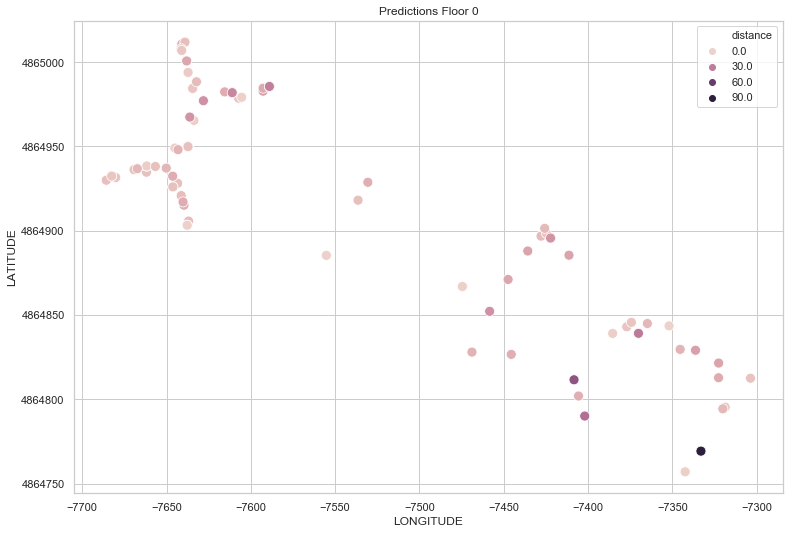

Text(0.5, 1.0, 'Real Values Floor 0')

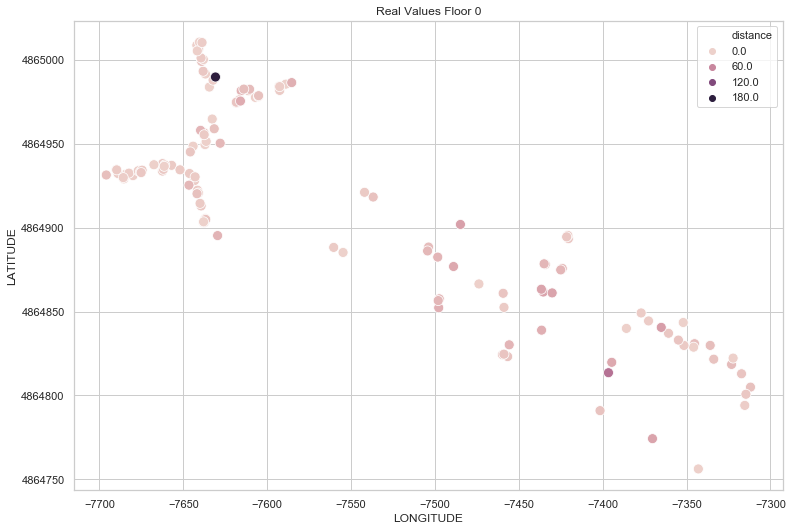

Text(0.5, 1.0, 'Predictions Floor 1')

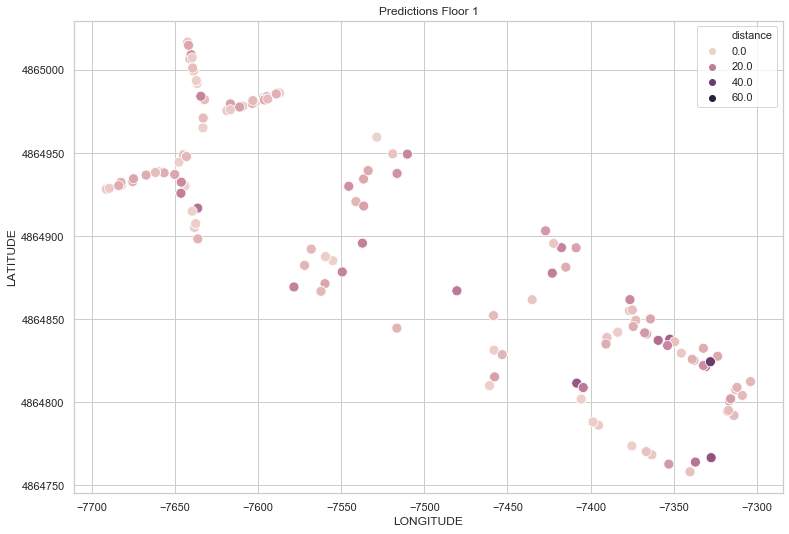

Text(0.5, 1.0, 'Real Values Floor 1')

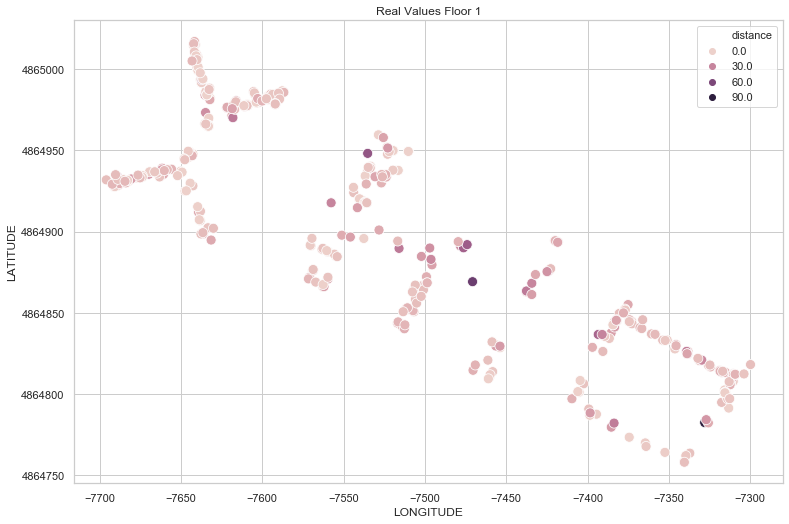

Text(0.5, 1.0, 'Predictions Floor 1')

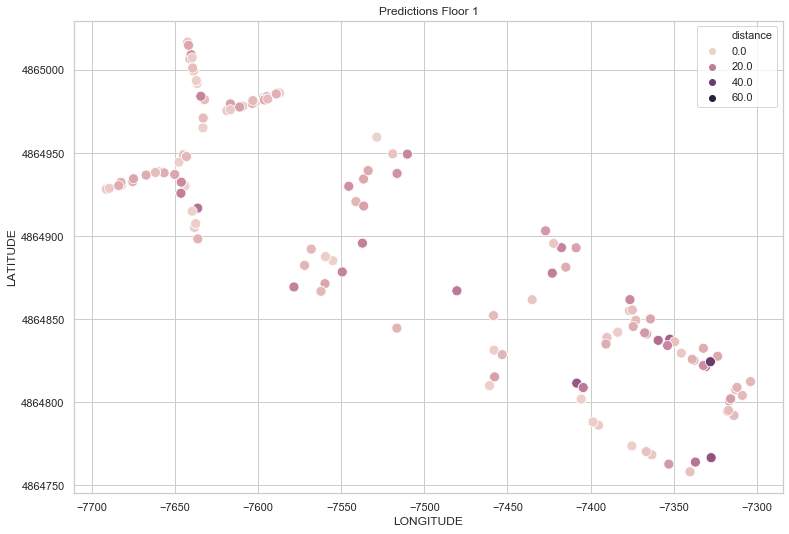

Text(0.5, 1.0, 'Real Values Floor 1')

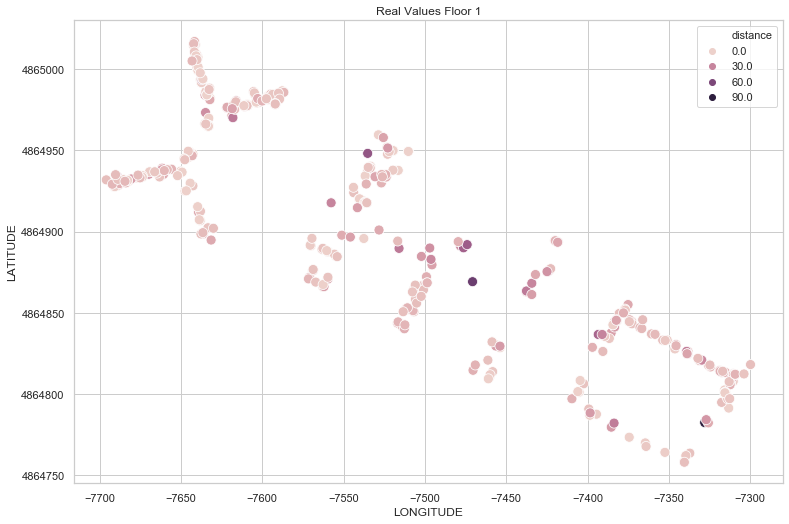

Text(0.5, 1.0, 'Predictions Floor 2')

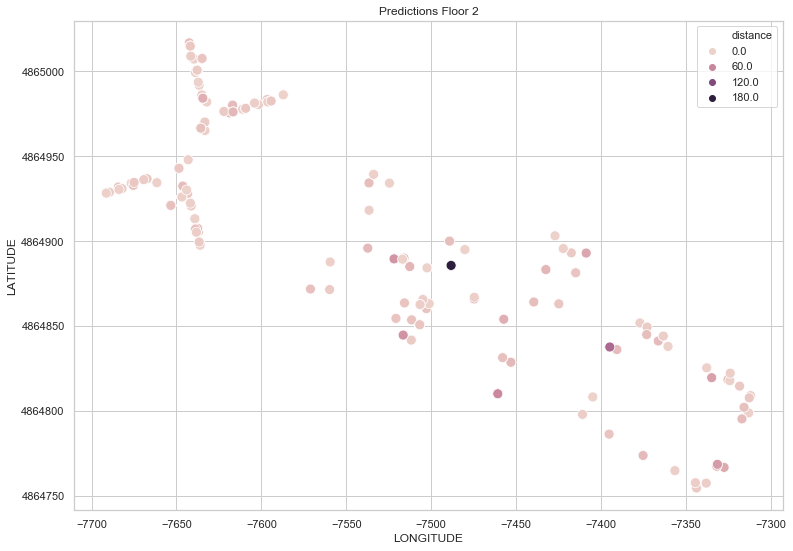

Text(0.5, 1.0, 'Real Values Floor 2')

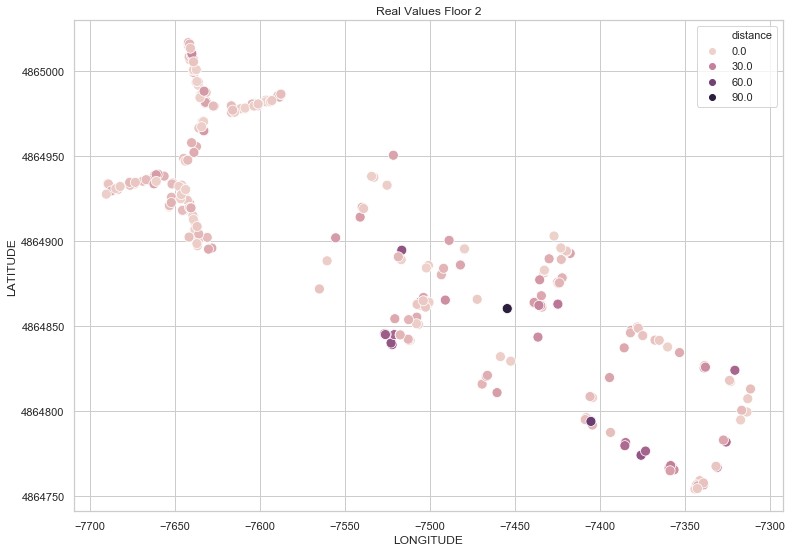

Text(0.5, 1.0, 'Predictions Floor 3')

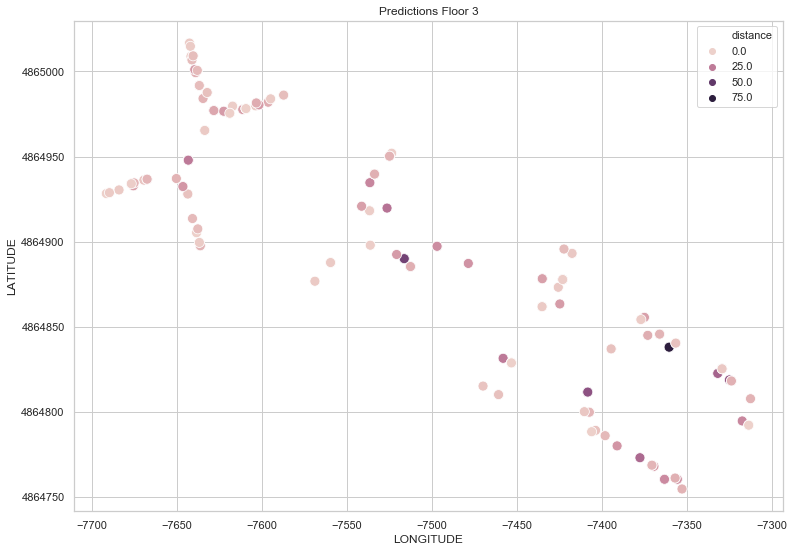

Text(0.5, 1.0, 'Real Values Floor 3')

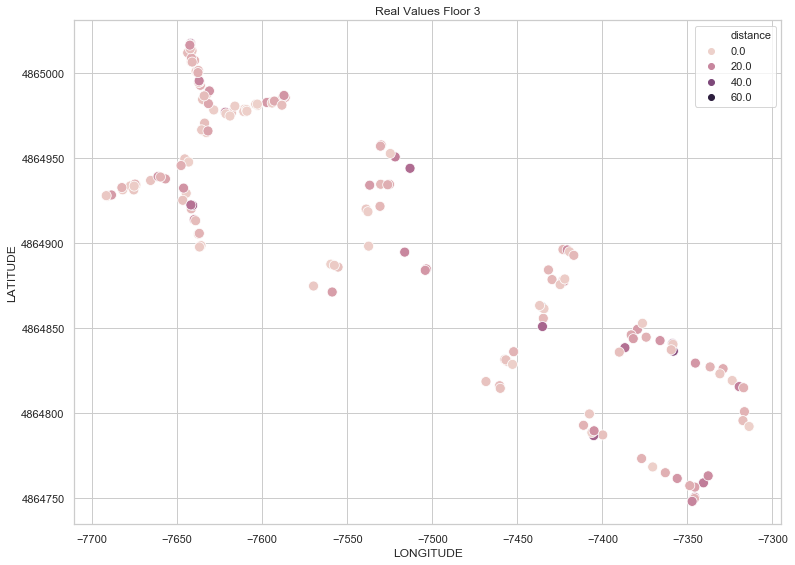

Text(0.5, 1.0, 'Predictions Floor 4')

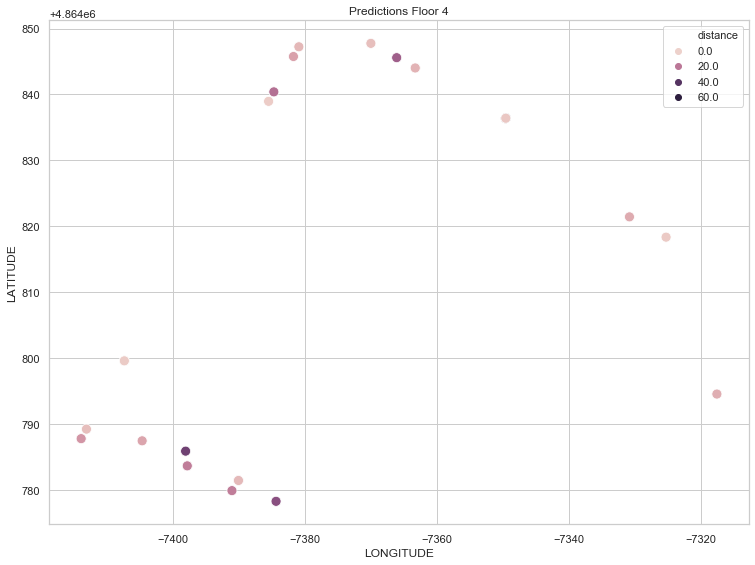

Text(0.5, 1.0, 'Real Values Floor 4')

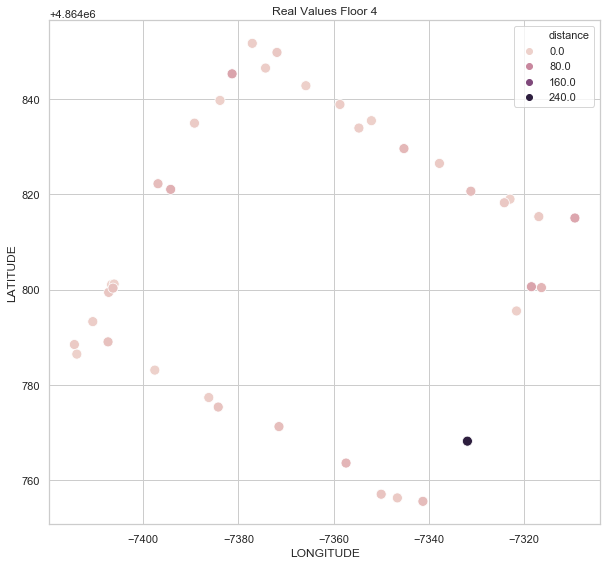

In [8]:

print(f"Mean error in meters {score}")

for floor in sorted(predictions.FLOOR.unique()):
    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        ax=ax,
        s=100,
        data=predictions[predictions["FLOOR"] == int(floor)],
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Predictions Floor {int(floor)}")
    plt.show()

    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        s=100,
        data=true_values[true_values["FLOOR"] == int(floor)],
        ax=ax,
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Real Values Floor {int(floor)}")
    plt.show()



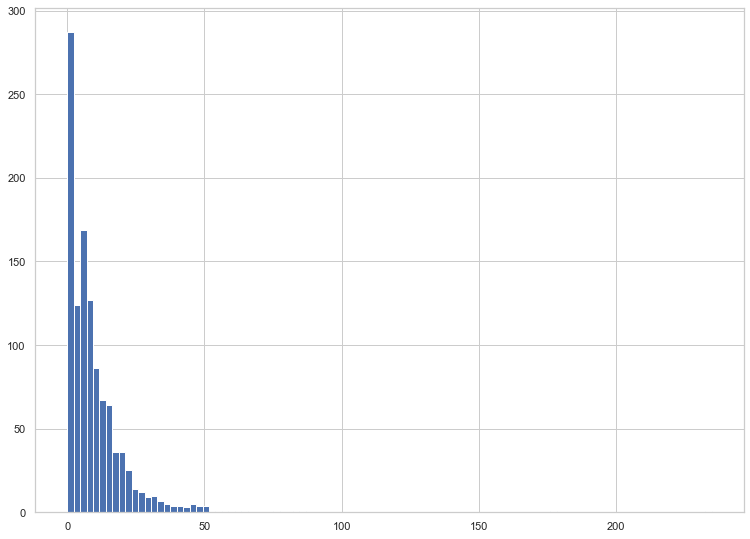

In [9]:

predictions.distance.hist(bins=100)

